#A01702752 Cristian Espinosa Díaz

# Módulo 1 Utilización, procesamiento y visualización de grandes volúmenes de datos (Portafolio Análisis)

Instalamos pyspark y java

In [ ]:
#Bibliotecas para poder trabajar con Spark
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.4.1//spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
#Configuración de Spark con Python
!pip install -q findspark
!pip install pyspark

#Estableciendo variable de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

#Buscando e inicializando la instalación de Spark
import findspark
findspark.init()
findspark.find()

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 119 kB in 2s (68.7 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
20 packages can be upgraded. Run 'apt list --upgradable' to see them.


'/content/spark-3.4.1-bin-hadoop3'

# Importamos nuestro dataset

El dataset escogido fue extraído de [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if).
Este dataset proporciona información sobre datos de accidentes de tráfico en las calles de la ciudad dentro de los límites de la Ciudad de Chicago y bajo la jurisdicción del Departamento de Policía de Chicago (CPD).

Estos datos provienen del sistema de informes electrónicos de accidentes (E-Crash) del CPD y se presentan tal como están, sin incluir información personal identificable. Los registros se añaden al portal de datos cuando se finaliza un informe de accidente o cuando se realizan modificaciones en un informe existente en E-Crash.

Los datos de E-Crash están disponibles para algunos distritos policiales a partir de 2015, pero los datos de toda la ciudad no están disponibles hasta septiembre de 2017.

El objetivo que tendrá el modelo será predecir si un accidente tendrá o no una persona lastimada.

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")
!pwd
#put your own path in google drive
%cd "/content/gdrive/MyDrive/Colab Notebooks/Archivos"
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/Archivos
/content/gdrive/MyDrive/Colab Notebooks/Archivos
 CNN_Model.png		      part2.csv			     'Summary of Weather.csv'
 Dataset		      part4.csv			      titanic.csv
 FastFoodNutritionMenu.csv    Raisin_Dataset.xlsx	      Traffic_Crashes_Chicago.csv
 FastFoodNutritionMenu.xlsx   spark-3.4.1-bin-hadoop3	      UserCarDataExample.csv
 Food_Inspections.csv	      spark-3.4.1-bin-hadoop3.tgz     Vegetables
 iris.data		      spark-3.4.1-bin-hadoop3.tgz.1   wine.data
 model.h5		      spark-3.4.1-bin-hadoop3.tgz.2  'winequality-red (1).csv'


# Instalamos las librerías necesarias para la ejecución del modelo y la preparación de los datos que realizaremos a continuación. A su vez creamos la sesión de Spark y el dataframe inicial.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when, col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, expr
from pyspark.sql import functions as F

# Inicializa una sesión de Spark
spark = SparkSession.builder.appName("EjemploCSV").getOrCreate()

# Reemplaza 'nombre_del_archivo.csv' con la ruta al archivo CSV
nombre_archivo_csv = 'Traffic_Crashes_Chicago.csv'

# Lee el archivo CSV y crea un DataFrame
data = spark.read.csv(nombre_archivo_csv, header=True, inferSchema=True)

**Imprimimos el esquema para verificar que el datset fue importado con éxito y para determinar que atributos serán relevantes para la predicción.**

In [ ]:
data.printSchema()

root
 |-- CRASH_RECORD_ID: string (nullable = true)
 |-- RD_NO: string (nullable = true)
 |-- CRASH_DATE_EST_I: string (nullable = true)
 |-- CRASH_DATE: string (nullable = true)
 |-- POSTED_SPEED_LIMIT: integer (nullable = true)
 |-- TRAFFIC_CONTROL_DEVICE: string (nullable = true)
 |-- DEVICE_CONDITION: string (nullable = true)
 |-- WEATHER_CONDITION: string (nullable = true)
 |-- LIGHTING_CONDITION: string (nullable = true)
 |-- FIRST_CRASH_TYPE: string (nullable = true)
 |-- TRAFFICWAY_TYPE: string (nullable = true)
 |-- LANE_CNT: integer (nullable = true)
 |-- ALIGNMENT: string (nullable = true)
 |-- ROADWAY_SURFACE_COND: string (nullable = true)
 |-- ROAD_DEFECT: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- INTERSECTION_RELATED_I: string (nullable = true)
 |-- NOT_RIGHT_OF_WAY_I: string (nullable = true)
 |-- HIT_AND_RUN_I: string (nullable = true)
 |-- DAMAGE: string (nullable = true)
 |-- DATE_POLICE_NOTIFIED

Algunas columnas como 'RD_NO' serán eliminadas debido a que la institución al anonimizar los datos por razones de privacidad dejó estas columnas vacías por lo que no tendrán mucha información que aportar al modelo.

Posteriormente, se eliminarán columnas como 'CRASH_RECORD_ID' debido a que la información que contienen estas columnas no es relevante para el objetivo del modelo.

Solo mantendremos 8 columnas, las cuales son:
* TRAFFIC_CONTROL_DEVICE
* WEATHER_CONDITION
* LIGHTING_CONDITION
* FIRST_CRASH_TYPE
* TRAFFICWAY_TYPE
* ROADWAY_SURFACE_COND
* ROAD_DEFECT
* INJURIES_TOTAL

Esta decisión fue tomada por medio de realizar diversas gráficas y observar el comportamiento de las primeras 7 columnas, de la lista que se mencionó anteriormente, con la columna dependiente "INJURIES_TOTAL".

Otro aspecto que se tomó en consideración fue que muchos aspectos poseen correlación de manera lógica. Ej: que el clima puede influir en el aumento de accidentes y por consecuencia, el aumento de posibles heridos.

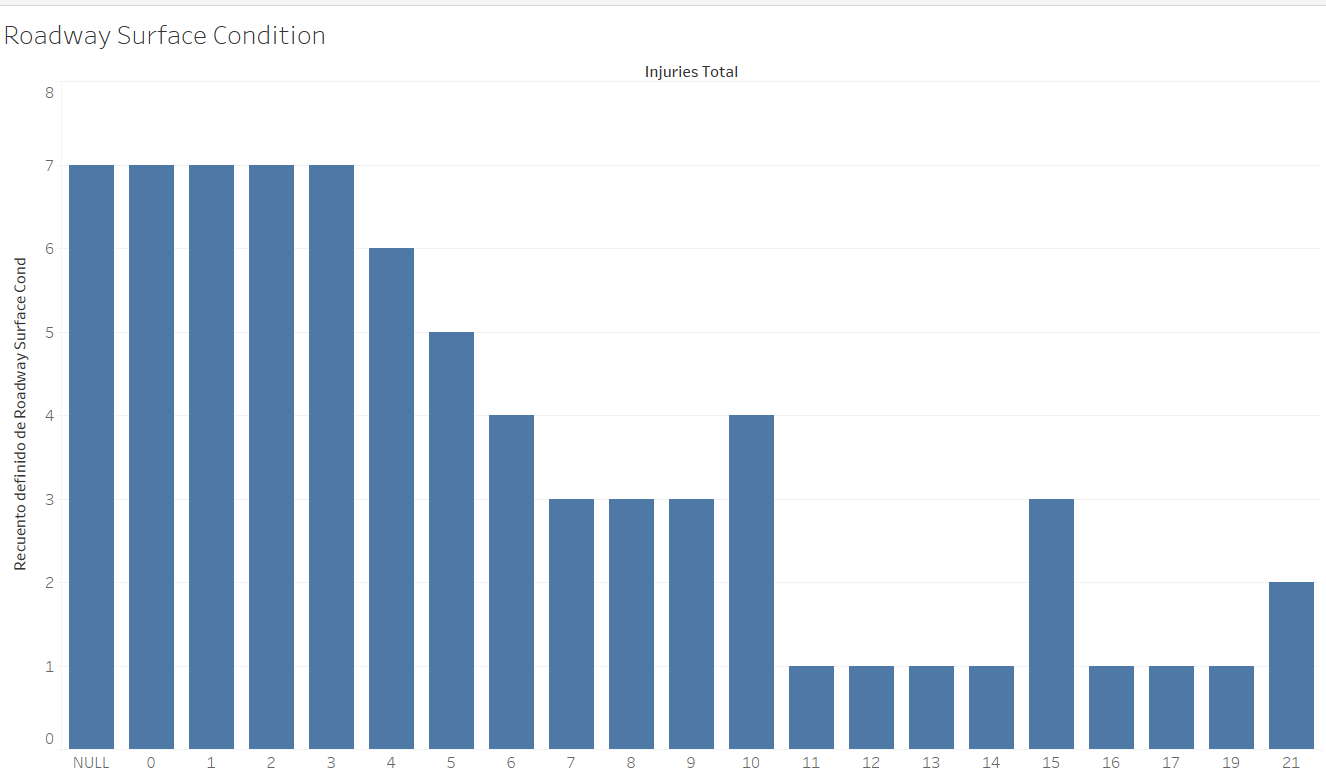

In [ ]:
# List of columns to keep
columns_to_keep = [
    "TRAFFIC_CONTROL_DEVICE",
    "WEATHER_CONDITION",
    "LIGHTING_CONDITION",
    "FIRST_CRASH_TYPE",
    "TRAFFICWAY_TYPE",
    "ROADWAY_SURFACE_COND",
    "ROAD_DEFECT",
    "INJURIES_TOTAL"
]

selected_data = data.select(*columns_to_keep)
selected_data.show()

+----------------------+-----------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------+
|TRAFFIC_CONTROL_DEVICE|WEATHER_CONDITION|  LIGHTING_CONDITION|    FIRST_CRASH_TYPE|     TRAFFICWAY_TYPE|ROADWAY_SURFACE_COND|ROAD_DEFECT|INJURIES_TOTAL|
+----------------------+-----------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------+
|                 OTHER|            CLEAR|            DAYLIGHT|            REAR END|               OTHER|                 DRY| NO DEFECTS|             1|
|        TRAFFIC SIGNAL|            CLEAR|            DAYLIGHT|PARKED MOTOR VEHICLE|DIVIDED - W/MEDIA...|                 DRY| NO DEFECTS|             0|
|           NO CONTROLS|            CLEAR|            DAYLIGHT|        PEDALCYCLIST|         NOT DIVIDED|                 DRY| NO DEFECTS|             1|
|           NO CONTROLS|            CLEAR|            DAYLIGHT|          PED

Nos aseguramos de eliminar las filas con información faltante por medio de la función 'drop.na()'

In [ ]:
selected_data = selected_data.dropna()

Convertimos las variables categóricas en númericas por medio de la función 'StringIndexer'. A su vez, convertimos la columna de 'INJURIES_TOTAL' de entero a booleana.

In [ ]:
# List of columns to be indexed
columns_to_index = [
    "TRAFFIC_CONTROL_DEVICE",
    "WEATHER_CONDITION",
    "LIGHTING_CONDITION",
    "FIRST_CRASH_TYPE",
    "TRAFFICWAY_TYPE",
    "ROADWAY_SURFACE_COND",
    "ROAD_DEFECT",
]

# Create a list of StringIndexers
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_LABELED", handleInvalid="skip")
    for col in columns_to_index
]

# Apply the transformations
indexed_df = selected_data

for indexer in indexers:
    indexed_df = indexer.fit(indexed_df).transform(indexed_df)


In [ ]:
# Use withColumn to create a boolean column based on the condition
indexed_df = indexed_df.withColumn("INJURIES_TOTAL_LABELED", F.when(indexed_df["INJURIES_TOTAL"] == 0, 0).otherwise(1))

Imprimimos el esquema nuevamente para verificar que nuestras columnas con los datos en formato numérico se crearon con éxito, estas columnas poseen la terminación '_LABELED'.

In [ ]:
indexed_df.printSchema()

root
 |-- TRAFFIC_CONTROL_DEVICE: string (nullable = true)
 |-- WEATHER_CONDITION: string (nullable = true)
 |-- LIGHTING_CONDITION: string (nullable = true)
 |-- FIRST_CRASH_TYPE: string (nullable = true)
 |-- TRAFFICWAY_TYPE: string (nullable = true)
 |-- ROADWAY_SURFACE_COND: string (nullable = true)
 |-- ROAD_DEFECT: string (nullable = true)
 |-- INJURIES_TOTAL: integer (nullable = true)
 |-- TRAFFIC_CONTROL_DEVICE_LABELED: double (nullable = false)
 |-- WEATHER_CONDITION_LABELED: double (nullable = false)
 |-- LIGHTING_CONDITION_LABELED: double (nullable = false)
 |-- FIRST_CRASH_TYPE_LABELED: double (nullable = false)
 |-- TRAFFICWAY_TYPE_LABELED: double (nullable = false)
 |-- ROADWAY_SURFACE_COND_LABELED: double (nullable = false)
 |-- ROAD_DEFECT_LABELED: double (nullable = false)
 |-- INJURIES_TOTAL_LABELED: integer (nullable = false)



Ingresamos todas las variables independientes en un vector usando 'VectorAssembler', posteriormente se integran al dataframe utilizando un 'transform'.

In [ ]:
# Assuming you have feature columns named "feature1," "feature2," etc.
feature_columns = ["TRAFFIC_CONTROL_DEVICE_LABELED", "WEATHER_CONDITION_LABELED", "LIGHTING_CONDITION_LABELED", "FIRST_CRASH_TYPE_LABELED", "TRAFFICWAY_TYPE_LABELED", "ROADWAY_SURFACE_COND_LABELED", "ROAD_DEFECT_LABELED"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="Independent Features")
result = assembler.transform(indexed_df)

Construimos nuestro modelo de regresión mediante la selección de la columna donde integramos los valores de las variables independientes y la columna que representa la variable dependiente.

In [ ]:
final_data = result.select("Independent features", "INJURIES_TOTAL_LABELED")
final_data.show()

+--------------------+----------------------+
|Independent features|INJURIES_TOTAL_LABELED|
+--------------------+----------------------+
|(7,[0,3,4],[4.0,1...|                     1|
| (7,[0,4],[1.0,1.0])|                     0|
|       (7,[3],[7.0])|                     1|
| (7,[3,4],[6.0,2.0])|                     1|
| (7,[3,4],[5.0,6.0])|                     0|
|[1.0,0.0,0.0,3.0,...|                     0|
|(7,[2,3,4],[1.0,1...|                     0|
| (7,[3,4],[4.0,6.0])|                     0|
|[1.0,0.0,1.0,3.0,...|                     0|
|(7,[2,3,4],[2.0,1...|                     0|
|[0.0,3.0,1.0,4.0,...|                     0|
| (7,[3,4],[2.0,3.0])|                     0|
| (7,[3,4],[2.0,6.0])|                     0|
|[0.0,2.0,3.0,4.0,...|                     0|
|[1.0,0.0,2.0,8.0,...|                     0|
| (7,[3,4],[1.0,2.0])|                     0|
| (7,[3,4],[8.0,2.0])|                     0|
|[2.0,0.0,1.0,3.0,...|                     0|
|[0.0,1.0,0.0,5.0,...|            

Del conjunto total de datos realizamos una división entre entrenamiento y prueba con la función 'randomSplit'.

In [ ]:
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed=123)

Creamos el modelo de regresión logística, en este caso será booleana para predecir si un accidente tandrá heridos o no.

In [ ]:
# Create a logistic regression model
model = LogisticRegression(labelCol="INJURIES_TOTAL_LABELED", featuresCol="Independent features", maxIter=100, regParam=0.01)


In [ ]:
model = model.fit(train_data)

Realizamos las predicciones y usamos a 'MulticlassClassificationEvaluator' para evaluar nuestro modelo por medio de las métricas de 'Accuracy' y 'F1 Score'.

In [ ]:
predictions = model.transform(test_data)

In [ ]:
# Create a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="INJURIES_TOTAL_LABELED", predictionCol="prediction", metricName="accuracy")
evaluator2 = MulticlassClassificationEvaluator(labelCol="INJURIES_TOTAL_LABELED", predictionCol="prediction", metricName="f1")

accuracy = evaluator.evaluate(predictions)
f1_score = evaluator2.evaluate(predictions)

print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

Accuracy: 0.8608367478973474
F1 Score: 0.8010057371672922


Accuracy (Precisión):

* El valor de precisión es 0.8608, lo que significa que el modelo de regresión logística es capaz de predecir correctamente el resultado en aproximadamente el 86.08% de los casos.

* Un alto valor de precisión sugiere que el modelo es efectivo en la clasificación de los datos y en la toma de decisiones correctas.

F1 Score:

* El valor del puntaje F1 es 0.8010, lo que indica un buen equilibrio entre la precisión y la exhaustividad (recall) del modelo.

* El puntaje F1 es una métrica que combina tanto la precisión como la exhaustividad en una sola métrica. Proporciona una medida de la precisión del modelo teniendo en cuenta tanto los falsos positivos como los falsos negativos.

* Un valor de F1 Score de 0.8010 sugiere que el modelo es capaz de lograr un equilibrio entre minimizar tanto los falsos positivos como los falsos negativos, lo que es deseable en muchas aplicaciones.

En resumen, estos resultados indican que el modelo de regresión logística tiene un buen rendimiento en términos de precisión y un equilibrio razonable entre precisión y exhaustividad, lo que sugiere que es un modelo sólido para la predicción de si un accidente tendrá lesionados con base a las variables independientes.

Realizamos predicciones para observar el funcionamiento del modelo obtenido.

Las columnas rawPrediction y probability son componentes esenciales de un modelo de regresión logística y se utilizan para evaluar la confianza del modelo en sus predicciones y para obtener las probabilidades de pertenencia a una clase en una tarea de clasificación binaria.

In [ ]:
prediction_result = model.evaluate(test_data)
prediction_result.predictions.show()

+--------------------+----------------------+--------------------+--------------------+----------+
|Independent features|INJURIES_TOTAL_LABELED|       rawPrediction|         probability|prediction|
+--------------------+----------------------+--------------------+--------------------+----------+
|           (7,[],[])|                     0|[2.40560599419750...|[0.91725379088488...|       0.0|
|           (7,[],[])|                     0|[2.40560599419750...|[0.91725379088488...|       0.0|
|           (7,[],[])|                     0|[2.40560599419750...|[0.91725379088488...|       0.0|
|           (7,[],[])|                     0|[2.40560599419750...|[0.91725379088488...|       0.0|
|           (7,[],[])|                     0|[2.40560599419750...|[0.91725379088488...|       0.0|
|           (7,[],[])|                     0|[2.40560599419750...|[0.91725379088488...|       0.0|
|           (7,[],[])|                     0|[2.40560599419750...|[0.91725379088488...|       0.0|
|         

In [ ]:
# Guardamos nuestro modelo para cargarlo después, en caso de ser necesario
model.save("TrafficInjuries_ClassificationModel.dt")

In [ ]:
#spark.stop()